In [109]:
# Import necessary libraries
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd, MultiComparison
from statannot import add_stat_annotation
from statsmodels.stats.multicomp import pairwise_tukeyhsd, MultiComparison
from statannotations.Annotator import Annotator
import scipy.stats as stats
from scipy.stats import bootstrap
from itertools import combinations

# Define color palette
colors = ['#DC8847', '#3E647D', '#82C0E9', '#C10534', '#90353B', '#BFA19C', '#CC6666', '#006666']

# Set matplotlib parameters
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['font.family'] = 'Arial'

os.getcwd()

# Initialize an empty DataFrame
dfs = pd.DataFrame([])

# Get a list of all CSV files in the current directory
file_list = glob.glob("*.csv")

# Iterate through each CSV file
for file_path in file_list:
    # Read the CSV file into a DataFrame
    df = pd.read_csv(file_path)
    
    # Extract the file name (without extension) and add it as a 'Name' column
    df['Name'] = file_path.split('.')[0]
    
    # Concatenate the DataFrame to the main DataFrame (dfs), excluding the first two columns
    dfs = pd.concat([dfs, df.iloc[:, 2:]], ignore_index=True)

# generate result dataframe
result = dfs.groupby('Name').agg({'median', 'std', 'count'})

# Define a function to calculate the 95% confidence interval for the median
def median_ci(data):
    median = np.median(data)
    n = len(data)
    z_critical = 1.96  # for a 95% confidence interval
    std_error = np.std(data) / np.sqrt(n)
    lower_ci = median - z_critical * std_error
    upper_ci = median + z_critical * std_error
    return lower_ci, upper_ci

# Apply the function to the 'median' column
result['median_ci'] = dfs.groupby('Name')['EdgeDistance'].apply(median_ci)

# Display the resulting DataFrame
result

EdgeDistance                     \
                 median  count         std   
Name                                         
NN_control   248.984049   8614  200.682291   
NN_haigg     203.018454  12297  160.014772   
NN_igg       211.583312   6013  185.231055   
NN_s2        201.846696   6522  166.322087   
NN_s4        199.011786   9572  166.566141   
NN_s5        203.719475   9109  162.744004   
NN_scfc      312.409723   2405  265.708355   
NN_vlp       253.436224   3378  187.147832   

                                           median_ci  
                                                      
Name                                                  
NN_control  (244.74627772639047, 253.22181959967173)  
NN_haigg    (200.19032735022174, 205.84658126277557)  
NN_igg      (206.90177826720904, 216.26484567659915)  
NN_s2       (197.81040673342102, 205.88298565888988)  
NN_s4       (195.67507348915203, 202.34849811062955)  
NN_s5        (200.3775105287428, 207.06144023565616)  
NN_scfc      (301.7924394799544, 323.02700742931904)  
NN_vlp        (247.1259712790816, 259.7464768420074)

NN_control vs. NN_vlp: Mann-Whitney-Wilcoxon test two-sided, P_val:8.499e-01 U_stat=1.452e+07
NN_control vs. NN_s2: Mann-Whitney-Wilcoxon test two-sided, P_val:6.379e-68 U_stat=3.273e+07
NN_control vs. NN_s4: Mann-Whitney-Wilcoxon test two-sided, P_val:7.656e-84 U_stat=4.808e+07
NN_control vs. NN_s5: Mann-Whitney-Wilcoxon test two-sided, P_val:3.915e-76 U_stat=4.552e+07
NN_control vs. NN_scfc: Mann-Whitney-Wilcoxon test two-sided, P_val:1.724e-27 U_stat=8.860e+06
NN_control vs. NN_haigg: Mann-Whitney-Wilcoxon test two-sided, P_val:4.202e-88 U_stat=6.151e+07
NN_control vs. NN_igg: Mann-Whitney-Wilcoxon test two-sided, P_val:1.214e-35 U_stat=2.903e+07


meta NOT subset; don't know how to subset; dropped


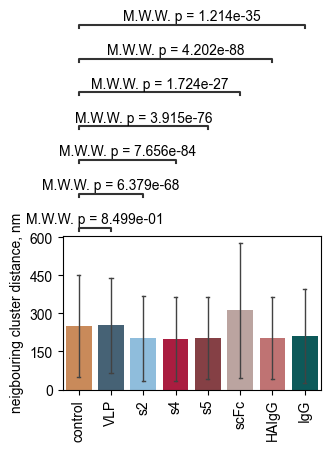

In [101]:
# Define color palette
colors = ['#DC8847', '#3E647D', '#82C0E9', '#C10534', '#90353B', '#BFA19C', '#CC6666', '#006666']

#Define order
order = ['NN_control', 'NN_vlp', 'NN_s2', 'NN_s4', 'NN_s5','NN_scfc', 'NN_haigg', 'NN_igg' ]

# Set up the figure and axis
fig, ax = plt.subplots(figsize=(5/1.5, 2))

# Set the number of major ticks on the y-axis
num_major_ticks = 6
ax.yaxis.set_major_locator(MaxNLocator(integer=True, nbins=num_major_ticks))

# Define the variable
y = 'EdgeDistance'

# Use sns.barplot for the plot
sns.barplot(
    data=dfs,
    x='Name',
    y=y,
    estimator=np.median,
    ci='sd',
    palette=colors,
    order=order,
    capsize=0.1,
    errwidth=1,
    dodge=True,
    ax=ax  # specify the axis to use
)

# Annotate with statistical significance
annot = Annotator(ax, [("NN_control", other) for other in ['NN_haigg', 'NN_igg', 'NN_s2', 'NN_s4', 'NN_s5', 'NN_scfc', 'NN_vlp']],
                  data=dfs, y=y, x='Name', order=order)
annot.configure(test='Mann-Whitney', text_format='full', loc='outside', verbose=2)
annot.apply_test()
ax, test_results = annot.annotate()

new_labels = ['control', 'VLP', 's2', 's4', 's5', 'scFc', 'HAIgG', 'IgG']

# Set the axis labels
ax.set_xticks(range(len(new_labels)))
ax.set_xticklabels(new_labels, rotation=90)
ax.set_xlabel('')
ax.set_ylabel('neigbouring cluster distance, nm')
# Save the figure
plt.savefig(y+'.pdf')

In [97]:
# Perform pairwise comparisons using Mann-Whitney U test
for sample1, sample2 in combinations(dfs['Name'].unique(), 2):
    sample1_clusters = dfs.loc[dfs['Name'] == sample1, 'EdgeDistance']
    sample2_clusters = dfs.loc[dfs['Name'] == sample2, 'EdgeDistance']
    
    result = stats.mannwhitneyu(sample1_clusters, sample2_clusters)
    
    print(f"Mann-Whitney U test results for {sample1} vs {sample2}:")
    print("-----------------------------------------------------")
    print("U-value:", result.statistic)
    print("p-value:", result.pvalue)

Mann-Whitney U test results for NN_control vs NN_haigg:
-----------------------------------------------------
U-value: 61512410.0
p-value: 4.2024654059143875e-88
Mann-Whitney U test results for NN_control vs NN_igg:
-----------------------------------------------------
U-value: 29029204.0
p-value: 1.2140615517125795e-35
Mann-Whitney U test results for NN_control vs NN_s2:
-----------------------------------------------------
U-value: 32726205.0
p-value: 6.379210743942789e-68
Mann-Whitney U test results for NN_control vs NN_s4:
-----------------------------------------------------
U-value: 48084716.0
p-value: 7.656201317974532e-84
Mann-Whitney U test results for NN_control vs NN_s5:
-----------------------------------------------------
U-value: 45518671.0
p-value: 3.9150274214335103e-76
Mann-Whitney U test results for NN_control vs NN_scfc:
-----------------------------------------------------
U-value: 8859958.0
p-value: 1.7244974195588912e-27
Mann-Whitney U test results for NN_control 